In [3]:
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2

In [4]:
import functools
from absl import logging

import jax
from jax import random
import jax.numpy as jnp

from flax import jax_utils
from flax.training import common_utils

import ml_collections

from data import input_pipeline
import models

import wandb

import numpy as np
import utils

from configs.eval_merge import get_config

import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from utils import restore_checkpoint

import merging
import models


from trainer import compute_metrics 

2024-08-05 13:07:14.810293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 13:07:14.840390: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 13:07:14.840426: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-05 13:07:16.132410: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/h/ekansh/condaenvs/jax-0.4.23/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLE

KeyboardInterrupt: 

In [ ]:
def get_metrics(metrics):
  return common_utils.stack_forest(metrics)

  
@functools.partial(jax.jit, static_argnums=(0,))
def eval_step(apply_fn, params, batch):
    variables = {'params': params}
    logits = apply_fn(variables, batch['image'])
    metrics = compute_metrics(logits, batch['label'])  
    return metrics


def compute_loss_and_accuracy(params, apply_fn, dataset, nbatches=None):
  eval_iter = input_pipeline.prefetch(dataset, 10, None)
  eval_metrics = []
  ix = 0
  for eval_batch in eval_iter:
      metrics = eval_step(apply_fn, params, eval_batch)
      eval_metrics.append(metrics)
      ix+=1
      if nbatches is not None:
          if ix >= nbatches:
              break
  
  eval_metrics = get_metrics(eval_metrics)
  summary = {
          f'eval_{k}': v
          for k, v in jax.tree_util.tree_map(
              lambda x: x.mean(), eval_metrics
          ).items()
      }

  return summary['eval_loss'], summary['eval_accuracy']



In [ ]:
config = get_config(f'VGG16,cifar10.cifar100.eurosat.resisc45.stanford_dogs,mgda-merging')
config.width_multiplier = 2
config.cifar10.model_dir = '../checkpoint/VGG16x2/finetuned_imagenet2012_96_13/cifar10_96/sgd/epochs_40_0/cosine_1e-2/seed_0/12980603/'
config.cifar10.init_model_dir = '../checkpoint/VGG16x2/finetuned_imagenet2012_96_13/cifar10_96/sgd/epochs_40_0/cosine_1e-2/seed_0/12980603/init'
config.cifar100.model_dir = '../checkpoint/VGG16x2/finetuned_imagenet2012_96_13/cifar100_96/sgd/epochs_40_0/cosine_1e-3/seed_0/12980685'
config.cifar100.init_model_dir = '../checkpoint/VGG16x2/finetuned_imagenet2012_96_13/cifar100_96/sgd/epochs_40_0/cosine_1e-3/seed_0/12980685/init'
config.eurosat.model_dir = '../checkpoint/VGG16x2/finetuned_imagenet2012_96_13/eurosat_96/sgd/epochs_40_0/cosine_1e-3/seed_0/12980688'
config.eurosat.init_model_dir = '../checkpoint/VGG16x2/finetuned_imagenet2012_96_13/eurosat_96/sgd/epochs_40_0/cosine_1e-3/seed_0/12980688/init'
config.resisc45.model_dir = '../checkpoint/VGG16x2/finetuned_imagenet2012_96_13/resisc45_96/sgd/epochs_40_0/cosine_1e-3/seed_0/12980693/'
config.resisc45.init_model_dir = '../checkpoint/VGG16x2/finetuned_imagenet2012_96_13/resisc45_96/sgd/epochs_40_0/cosine_1e-3/seed_0/12980693/init'
config.stanford_dogs.model_dir = '../checkpoint/VGG16x2/finetuned_imagenet2012_96_13/stanford_dogs_96/sgd/epochs_40_0/cosine_1e-3/seed_0/12980694'
config.stanford_dogs.init_model_dir = '../checkpoint/VGG16x2/finetuned_imagenet2012_96_13/stanford_dogs_96/sgd/epochs_40_0/cosine_1e-3/seed_0/12980694/init'
config.cifar10.pp.crop = 96
config.cifar100.pp.crop = 96
config.eurosat.pp.crop = 96
config.resisc45.pp.crop = 96
config.stanford_dogs.pp.crop = 96

In [ ]:
from configs.eval_merge import get_config
config = get_config(f'ViTB32,cifar10.cifar100.eurosat.stanford_dogs,mgda-merging')
config.cifar10.model_dir = '../experiments/ViT-B-32/cifar10/adam_LR_1e-5_WD_1e-1/cosine/40_epochs_1_warmup/seed_0'
config.cifar10.init_model_dir = '../experiments/ViT-B-32/cifar10/adam_LR_1e-5_WD_1e-1/cosine/40_epochs_1_warmup/seed_0/init'
config.cifar100.model_dir = '../experiments/ViT-B-32/cifar100/adam_LR_1e-5_WD_1e-1/cosine/40_epochs_1_warmup/seed_0'
config.cifar100.init_model_dir = '../experiments/ViT-B-32/cifar100/adam_LR_1e-5_WD_1e-1/cosine/40_epochs_1_warmup/seed_0/init'
config.eurosat.model_dir = '../experiments/ViT-B-32/eurosat/adam_LR_1e-5_WD_1e-1/cosine/40_epochs_1_warmup/seed_0'
config.eurosat.init_model_dir = '../experiments/ViT-B-32/eurosat/adam_LR_1e-5_WD_1e-1/cosine/40_epochs_1_warmup/seed_0/init'
config.stanford_dogs.model_dir = '../experiments/ViT-B-32/stanford_dogs/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0'
config.stanford_dogs.init_model_dir = '../experiments/ViT-B-32/stanford_dogs/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/init'
config.resisc45.model_dir = '../experiments/ViT-B-32/resisc45/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/'
config.resisc45.init_model_dir = '../experiments/ViT-B-32/resisc45/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/init'

config.cifar10.pp.crop = 224
config.cifar100.pp.crop = 224
config.eurosat.pp.crop = 224
config.resisc45.pp.crop = 224

In [ ]:
from configs.eval_merge import get_config
config = get_config(f'ViTB32,cifar10.cifar100,mgda-merging')
config.cifar10.model_dir = '../experiments/ViT-B-32/cifar10/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/'
config.cifar10.init_model_dir = '../experiments/ViT-B-32/cifar10/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/init'
config.cifar100.model_dir = '../experiments/ViT-B-32/cifar100/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0'
config.cifar100.init_model_dir = '../experiments/ViT-B-32/cifar100/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/init'
config.eurosat.model_dir = '../experiments/ViT-B-32/eurosat/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0'
config.eurosat.init_model_dir = '../experiments/ViT-B-32/eurosat/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/init'
config.stanford_dogs.model_dir = '../experiments/ViT-B-32/stanford_dogs/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0'
config.stanford_dogs.init_model_dir = '../experiments/ViT-B-32/stanford_dogs/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/init'
config.resisc45.model_dir = '../experiments/ViT-B-32/resisc45/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/'
config.resisc45.init_model_dir = '../experiments/ViT-B-32/resisc45/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/init'

config.cifar10.pp.crop = 224
config.cifar100.pp.crop = 224
config.eurosat.pp.crop = 224
config.resisc45.pp.crop = 224

In [7]:
datasets = config.datasets
dataset_info_ls = [input_pipeline.get_dataset_info(dataset, config[dataset].pp['train']) for dataset in config.datasets]
num_classes = [dataset_info['num_classes'] for dataset_info in dataset_info_ls] 
num_train_examples = [dataset_info['num_examples'] for dataset_info in dataset_info_ls]

_, ds_test_ls = input_pipeline.get_datasets_for_mtl(config, datasets)



In [8]:
ntasks = len(num_classes)
model_ls = []
for nclass in num_classes:
    model_ls += [models.create_model(
                    model_cls= getattr(models, config.model), 
                    num_classes=nclass, 
                    width_multiplier=config.width_multiplier,
                    projection_dim=512, 
                    half_precision=config.half_precision) ]

## Get expert + init  models
expert_params_ls = []
init_params_ls = []
for dataset in datasets:
    print(f"Loading init and expert models for {dataset}.")
    expert_params_ls += [restore_checkpoint(config[dataset].model_dir)['params']]
    init_params_ls += [restore_checkpoint(config[dataset].init_model_dir)['params']]  

Loading init and expert models for cifar10.
Loading init and expert models for cifar100.


In [ ]:
from pyhessian import compute_density, compute_trace, compute_eigenvalues


In [ ]:
from flax import jax_utils



In [ ]:
from utils import tree_zeros_like, tree_scalar_multiply, tree_add
from pyhessian.hvp import compute_batch_hvp


def compute_hessian_vector_product(loss_fn, dataset, params, v, nbatches=None, axis_name=None):
    eval_iter =  input_pipeline.prefetch(dataset, 10, None)
    if axis_name is not None: 
        batch_hvp = jax.pmap(compute_batch_hvp, static_argnums=(0, 4))
    else:
        batch_hvp = jax.jit(compute_batch_hvp, static_argnums=(0, 4))
    N = 0
    Hv = tree_zeros_like(v)
    ix = 0
    
    if axis_name is not None:
        N_fn = lambda batch: batch['label'].shape[0] * batch['label'].shape[1]
    else:
        N_fn = lambda batch: batch['label'].shape[0] 
    
    for batch in eval_iter:
        batch_n = N_fn(batch)
        N += batch_n
        _Hv = batch_hvp(loss_fn, batch, params, v, axis_name)
        Hv = tree_add(Hv, tree_scalar_multiply(batch_n, _Hv))
        ix+=1
        if nbatches is not None:
          if ix >= nbatches:
              break
        
    return tree_scalar_multiply(1./N, Hv)


In [2]:
from trainer import cross_entropy_loss

def loss_fn(applyfn, batch, params):    
    logits = applyfn(
    {'params': params},
    batch['image'])
    loss = cross_entropy_loss(logits, batch['label'])
    return loss


ModuleNotFoundError: No module named 'trainer'

In [ ]:
compute_hessian_vector_product(lambda batch, params: loss_fn(model_ls[0].apply, batch, ), dataset, params, v, nbatches=None, axis_name=None)

In [ ]:

HVP = lambda params, v: compute_hessian_vector_product(loss_fn, ds_test_ls[0], params, v, nbatches=None)

In [14]:
trace = compute_trace(random.PRNGKey(10),HVP, expert_params_ls[0], tol = 1e-3)
print(jnp.mean(jnp.stack(trace)))

  1%|          | 1/100 [01:49<2:59:58, 109.08s/it]

6894.7056


2024-08-01 13:33:00.448414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
  2%|▏         | 2/100 [02:26<1:49:08, 66.82s/it] 

6335.7754


2024-08-01 13:33:37.419611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
  3%|▎         | 3/100 [03:03<1:25:55, 53.15s/it]

6057.2734


2024-08-01 13:34:14.251018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
  4%|▍         | 4/100 [03:40<1:14:43, 46.71s/it]

5570.7393


2024-08-01 13:34:50.661338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
  5%|▌         | 5/100 [04:16<1:08:04, 42.99s/it]

5458.91


2024-08-01 13:35:27.286049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
  6%|▌         | 6/100 [04:53<1:03:58, 40.83s/it]

5838.3257


2024-08-01 13:36:03.660330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
  6%|▌         | 6/100 [05:29<1:26:01, 54.91s/it]

5839.305


In [15]:
trace

[Array(6894.7056, dtype=float32),
 Array(5776.845, dtype=float32),
 Array(5500.2686, dtype=float32),
 Array(4111.1377, dtype=float32),
 Array(5011.5947, dtype=float32),
 Array(7735.4004, dtype=float32),
 Array(5845.1787, dtype=float32)]

In [17]:
trace = compute_trace(random.PRNGKey(10),HVP, expert_params_ls[0], tol=1e-3)
print(jnp.mean(jnp.stack(trace)))

  6%|▌         | 6/100 [04:17<1:07:18, 42.97s/it]

5832.596


In [18]:
trace

[Array(6886.1846, dtype=float32),
 Array(5770.9224, dtype=float32),
 Array(5494.73, dtype=float32),
 Array(4103.216, dtype=float32),
 Array(5003.029, dtype=float32),
 Array(7730.3623, dtype=float32),
 Array(5839.726, dtype=float32)]

In [20]:
trace = compute_trace(random.PRNGKey(10),HVP, init_params_ls[0], tol=1e-3)
print(jnp.mean(jnp.stack(trace)))

  1%|          | 1/100 [00:42<1:09:54, 42.37s/it]


KeyboardInterrupt: 

In [ ]:
from 

In [15]:
trace = compute_trace(random.PRNGKey(0),HVP, init_params_ls[0])
print(jnp.mean(jnp.stack(trace)))

100%|██████████| 100/100 [11:24<00:00,  6.85s/it]

nan


In [28]:
eig_init = compute_eigenvalues(random.PRNGKey(0),HVP, init_params_ls[0], top_n = 1)

In [27]:
eig_expert = compute_eigenvalues(random.PRNGKey(0),HVP, expert_params_ls[0], top_n = 1)

In [25]:
eig_init[0]

[Array(14053.352, dtype=float32)]

In [26]:
eig_expert[0]

[Array(14053.352, dtype=float32)]

In [14]:
eigenvals,  = compute_density(random.PRNGKey(0),HVP, expert_params_ls[0], n_eigs=20)


2024-08-01 10:56:39.951517: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
100%|██████████| 19/19 [00:15<00:00,  1.21it/s]
2024-08-01 10:56:57.850726: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
100%|██████████| 19/19 [00:14<00:00,  1.29it/s]
2024-08-01 10:57:13.426809: W tensorflow/core/kernels/da

In [16]:
from plotting import get_esd_plot

In [18]:
eigvals , weights = density

In [19]:
fig = get_esd_plot(eigvals, weights)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (2, 10, 20) + inhomogeneous part.

In [97]:
import math
import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

def get_esd_plot(eigenvalues, weights):
    density, grids = density_generate(eigenvalues, weights)
    plt.semilogy(grids, density + 1.0e-7)
    plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
    plt.xlabel('Eigenvlaue', fontsize=14, labelpad=10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axis([np.min(eigenvalues) - 1, np.max(eigenvalues) + 1, None, None])
    plt.tight_layout()
    plt.show()
    # plt.savefig('example.pdf')


def density_generate(eigenvalues,
                     weights,
                     num_bins=10000,
                     sigma_squared=1e-2,
                     overhead=0.01):

    eigenvalues = np.array(eigenvalues)
    weights = np.array(weights)

    lambda_max = np.mean(np.max(eigenvalues, axis=1), axis=0) + overhead
    lambda_min = np.mean(np.min(eigenvalues, axis=1), axis=0) - overhead

    grids = np.linspace(lambda_min, lambda_max, num=num_bins)
    sigma = sigma_squared * max(1, (lambda_max - lambda_min))

    num_runs = eigenvalues.shape[0]
    density_output = np.zeros((num_runs, num_bins))

    for i in range(num_runs):
        for j in range(num_bins):
            x = grids[j]
            tmp_result = gaussian(eigenvalues[i, :], x, sigma)
            density_output[i, j] = np.sum(tmp_result * weights[i, :])
    density = np.mean(density_output, axis=0)
    normalization = np.sum(density) * (grids[1] - grids[0])
    density = density / normalization
    return density, grids


def gaussian(x, x0, sigma_squared):
    return np.exp(-(x0 - x)**2 /
                  (2.0 * sigma_squared)) / np.sqrt(2 * np.pi * sigma_squared)

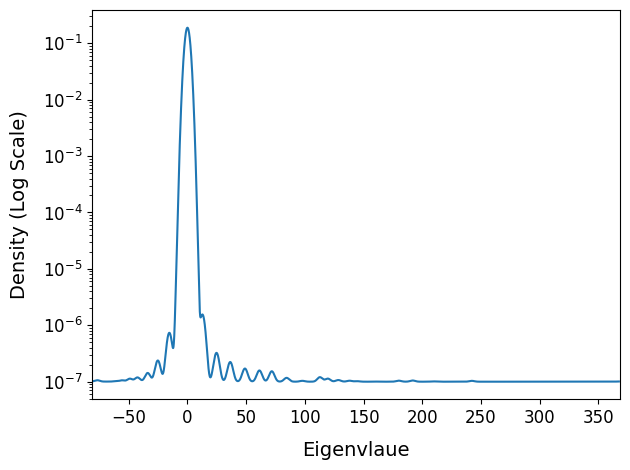

In [98]:
get_esd_plot(eigvals, weights)

In [90]:
len(eigvals[0])

40

In [36]:
density, grids = density_generate(density[0], density[1])

AxisError: axis 1 is out of bounds for array of dimension 0

In [31]:

plt.semilogy(grids, density + 1.0e-7)
plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
plt.xlabel('Eigenvlaue', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axis([np.min(density[0]) - 1, np.max(density[0]) + 1, None, None])
plt.tight_layout()
plt.show()


In [16]:
from typing import Sequence

import jax
import jax.numpy as jnp
import flax.linen as nn


class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.relu(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x


def compute_loss(variables, batch, label):
    output = model.apply({"params": variables}, batch)
    loss = jnp.sum((output - label)**2)
    return loss


model = MLP([8, 1])

In [17]:
rng = random.PRNGKey(0)
batch = jnp.ones((32, 10))
label = jnp.ones((32))
variables = model.init(jax.random.PRNGKey(0), batch)['params']
f = lambda param: compute_loss(param, batch, label)
loss = f(variables)

In [18]:
from pyhessian.hvp import hvp, vmap_hvp
from utils import normal_tree_like



hvp(f, variables, normal_tree_like(rng, variables))

{'Dense_0': {'bias': Array([    0.    ,  1357.4429,     0.    ,     0.    ,  2443.4028,
             0.    ,  1695.0197, -2380.2268], dtype=float32),
  'kernel': Array([[    0.    ,  1357.4432,     0.    ,     0.    ,  2443.4023,
              0.    ,  1695.0197, -2380.2268],
         [    0.    ,  1357.4432,     0.    ,     0.    ,  2443.4023,
              0.    ,  1695.0197, -2380.2268],
         [    0.    ,  1357.4432,     0.    ,     0.    ,  2443.4023,
              0.    ,  1695.0197, -2380.2268],
         [    0.    ,  1357.4432,     0.    ,     0.    ,  2443.4023,
              0.    ,  1695.0197, -2380.2268],
         [    0.    ,  1357.4432,     0.    ,     0.    ,  2443.4023,
              0.    ,  1695.0197, -2380.2268],
         [    0.    ,  1357.4432,     0.    ,     0.    ,  2443.4023,
              0.    ,  1695.0197, -2380.2268],
         [    0.    ,  1357.4432,     0.    ,     0.    ,  2443.4023,
              0.    ,  1695.0197, -2380.2268],
         [    0.    ,

In [19]:
rngs = random.split(rng, 10)

In [31]:

Hvs = vmap_hvp(f, variables, vs)

In [34]:
Hvs['Dense_0']['bias'].shape

(10, 8)

In [28]:
from utils import forest_stack
vs = forest_stack([normal_tree_like(r, variables) for  r in rngs])

In [107]:
from utils import normal_tree_like
hvp(f, [variables, ], [normal_tree_like(rng, variables), ])



{'Dense_0': {'bias': Array([    0.    ,  1357.4429,     0.    ,     0.    ,  2443.4028,
             0.    ,  1695.0197, -2380.2268], dtype=float32),
  'kernel': Array([[    0.    ,  1357.4432,     0.    ,     0.    ,  2443.4023,
              0.    ,  1695.0197, -2380.2268],
         [    0.    ,  1357.4432,     0.    ,     0.    ,  2443.4023,
              0.    ,  1695.0197, -2380.2268],
         [    0.    ,  1357.4432,     0.    ,     0.    ,  2443.4023,
              0.    ,  1695.0197, -2380.2268],
         [    0.    ,  1357.4432,     0.    ,     0.    ,  2443.4023,
              0.    ,  1695.0197, -2380.2268],
         [    0.    ,  1357.4432,     0.    ,     0.    ,  2443.4023,
              0.    ,  1695.0197, -2380.2268],
         [    0.    ,  1357.4432,     0.    ,     0.    ,  2443.4023,
              0.    ,  1695.0197, -2380.2268],
         [    0.    ,  1357.4432,     0.    ,     0.    ,  2443.4023,
              0.    ,  1695.0197, -2380.2268],
         [    0.    ,

In [103]:
from jax import jvp, grad

# forward-over-reverse
def hvp(f, primals, tangents):
  return jvp(grad(f), primals, tangents)[1]


In [88]:
rng = random.PRNGKey(0)

In [89]:
from pyhessian.hvp import hessian_vector_product
from utils import rademacher_tree_like

In [90]:
v = rademacher_tree_like(random.PRNGKey(100), variables)
Hv = hessian_vector_product(f, variables, v)
utils.tree_inner_prod(Hv, v)

Array(33678.418, dtype=float32)

In [91]:
from jax import jvp, grad

# forward-over-reverse
def hvp(f, primals, tangents):
  return jvp(grad(f), (primals, ) , (tangents, ))[1]


In [39]:

def f(X):
  return jnp.sum(jnp.tanh(X['val'])**2)

key, subkey1, subkey2 = random.split(rng, 3)
X = random.normal(subkey1, (30, 40))
V = random.normal(subkey2, (30, 40))



In [43]:
a = (20,10)

In [45]:
(10, ) + a 

(10, 20, 10)

{'val': Array([[ 0.06859969,  0.02169697, -0.04985059, ..., -0.01427879,
          0.09185548, -0.13751534],
        [ 0.16027963, -0.23671088,  0.32685554, ...,  0.83014745,
          0.645875  ,  1.2392514 ],
        [ 0.0720395 , -0.37492314,  0.4827116 , ...,  0.11219648,
         -0.06260625,  0.06483959],
        ...,
        [-3.1227844 , -0.6699797 , -0.48910147, ..., -0.3941704 ,
         -0.9792825 , -0.84505606],
        [ 2.2148695 , -1.0342036 , -0.49956036, ...,  0.3227569 ,
         -1.5029501 , -1.5642176 ],
        [-0.02710684,  2.6805763 , -0.9925634 , ..., -0.09553632,
         -1.8444042 , -0.36611918]], dtype=float32)}

In [69]:
Hv_ = hvp(f, (variables, ) , (v, ))

TypeError: primal and tangent arguments to jax.jvp do not match; dtypes must be equal, or in case of int/bool primal dtype the tangent dtype must be float0.Got primal dtype float32 and so expected tangent dtype float32, but got tangent dtype int32 instead.

(100, 2, 2)

In [54]:
Hv

{'Dense_0': {'bias': Array([    0.    , -1843.6448,     0.    ,     0.    , -1814.1292,
             0.    , -1814.465 ,  1825.4143], dtype=float32),
  'kernel': Array([[    0.    , -1843.6454,     0.    ,     0.    , -1814.1296,
              0.    , -1814.4651,  1825.4149],
         [    0.    , -1843.6454,     0.    ,     0.    , -1814.1296,
              0.    , -1814.4651,  1825.4149],
         [    0.    , -1843.6454,     0.    ,     0.    , -1814.1296,
              0.    , -1814.4651,  1825.4149],
         [    0.    , -1843.6454,     0.    ,     0.    , -1814.1296,
              0.    , -1814.4651,  1825.4149],
         [    0.    , -1843.6454,     0.    ,     0.    , -1814.1296,
              0.    , -1814.4651,  1825.4149],
         [    0.    , -1843.6454,     0.    ,     0.    , -1814.1296,
              0.    , -1814.4651,  1825.4149],
         [    0.    , -1843.6454,     0.    ,     0.    , -1814.1296,
              0.    , -1814.4651,  1825.4149],
         [    0.    ,

In [39]:
from jax.tree_util import tree_reduce, tree_flatten, tree_map


In [40]:
print(jax.tree_map(jnp.shape, hessian))


{'Dense_0': {'bias': {'Dense_0': {'bias': (8, 8), 'kernel': (8, 10, 8)}, 'Dense_1': {'bias': (8, 1), 'kernel': (8, 8, 1)}}, 'kernel': {'Dense_0': {'bias': (10, 8, 8), 'kernel': (10, 8, 10, 8)}, 'Dense_1': {'bias': (10, 8, 1), 'kernel': (10, 8, 8, 1)}}}, 'Dense_1': {'bias': {'Dense_0': {'bias': (1, 8), 'kernel': (1, 10, 8)}, 'Dense_1': {'bias': (1, 1), 'kernel': (1, 8, 1)}}, 'kernel': {'Dense_0': {'bias': (8, 1, 8), 'kernel': (8, 1, 10, 8)}, 'Dense_1': {'bias': (8, 1, 1), 'kernel': (8, 1, 8, 1)}}}}


In [41]:
print(jax.tree_map(jnp.shape, variables))


{'Dense_0': {'bias': (8,), 'kernel': (10, 8)}, 'Dense_1': {'bias': (1,), 'kernel': (8, 1)}}


In [52]:
hessian['Dense_0']['kernel']['Dense_0']['kernel'].shape

(10, 8, 10, 8)

In [53]:
hessian_vector_product(f, variables, )

ValueError: Expected dict, got Array([[-1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [-1]], dtype=int32).

In [13]:
from jax import hessian, grad
from jax import random
import jax.numpy as jnp
key = random.PRNGKey(0)

def f(X):
  return jnp.sum(jnp.tanh(X)**2)

key, subkey1, subkey2 = random.split(key, 3)
X = random.normal(subkey1, (30, 40))
V = random.normal(subkey2, (30, 40))



In [10]:
from jax import jvp

In [16]:
jvp(f, (X,), (V,))


(Array(478.88943, dtype=float32), Array(10.220588, dtype=float32))

In [15]:
jnp.vdot(grad(f)(X), X)

Array(442.30478, dtype=float32)

In [17]:
f(X)

Array(478.88943, dtype=float32)